<a href="https://colab.research.google.com/github/riyansmiha/Animel_Identification/blob/main/Identify_Domestic_Animal_(Final_Test)_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np 
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator 

In [ ]:
datapath = r"/content/drive/MyDrive/datasets/Animal"
outputmodel = r"/content/drive/MyDrive/datasets/Model"
outputlabelbinarizer = r"/content/drive/MyDrive/datasets/ModelBinarizer"
epoch = 25

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
Animal_Labels = set(['Cat', 'Cow', 'Dog', 'Goat']) 
print("Images is being loaded....") 
pathToImages = list(paths.list_images(datapath))
data = []
labels = []
for images in pathToImages:
    label = images.split(os.path.sep)[-2]
    if label not in Animal_Labels:
        continue
    image = cv2.imread(images)
    if (image is not None):
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
        image = cv2.resize(image, (224,224))
    data.append(image)
    labels.append(label) 

Images is being loaded....


In [ ]:
data = np.array(data)
labels = np.array(labels)
#hot encoded value as 0,1,2 
lb = LabelBinarizer() 
labels = lb.fit_transform(labels) 

In [ ]:
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size = 0.25, stratify = labels, random_state = 42) 

In [ ]:
traininAugmentation = ImageDataGenerator(
    rotation_range = 30,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    horizontal_flip = True, 
    fill_mode = 'nearest'
) 
validationAugmentation = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype = 'float32')
traininAugmentation.mean = mean
validationAugmentation.mean = mean

In [ ]:
from tensorflow.keras.applications import ResNet50

from keras.layers.pooling import AveragePooling2D
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout


baseModel = ResNet50(weights = "imagenet", 
                     include_top = False, input_tensor = Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size = (7, 7))(headModel)
headModel = Flatten(name = 'flatten')(headModel)
headModel = Dense(512, activation = 'relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation = 'softmax')(headModel)
model = Model(inputs = baseModel.input, outputs = headModel)

for basemodelLayers in baseModel.layers:
    basemodelLayers.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.optimizers import SGD
opt = SGD(lr = 0.0001, momentum = 0.9, decay = 1e-4/epoch)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy']) 

In [ ]:
History = model.fit_generator(
    traininAugmentation.flow(X_train, Y_train, batch_size = 32),
    steps_per_epoch = len(X_train) // 32,
    validation_data = validationAugmentation.flow(X_test, Y_test),
    validation_steps = len(X_test) // 32,
    epochs = epoch
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/25
234/234 [==============================] - 133s 509ms/step - loss: 1.0941 - accuracy: 0.5499 - val_loss: 0.4583 - val_accuracy: 0.8421
Epoch 2/25
234/234 [==============================] - 116s 496ms/step - loss: 0.6470 - accuracy: 0.7466 - val_loss: 0.3500 - val_accuracy: 0.8850
Epoch 3/25
234/234 [==============================] - 116s 495ms/step - loss: 0.5145 - accuracy: 0.8059 - val_loss: 0.3071 - val_accuracy: 0.8974
Epoch 4/25
234/234 [==============================] - 119s 510ms/step - loss: 0.4683 - accuracy: 0.8215 - val_loss: 0.2778 - val_accuracy: 0.9095
Epoch 5/25
234/234 [==============================] - 116s 497ms/step - loss: 0.4329 - accuracy: 0.8318 - val_loss: 0.2566 - val_accuracy: 0.9171
Epoch 6/25
234/234 [==============================] - 117s 498ms/step - loss: 0.4006 - accuracy: 0.8476 - val_loss: 0.2442 - val_accuracy: 0.9183
Epoch 7/25
234/234 [==============================] - 115s 492ms/step - loss: 0.3842 - accuracy: 0.8513 - val_loss: 0.2450 -

In [ ]:
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
print(History.history.keys) 

<built-in method keys of dict object at 0x7ffa6c655f50>


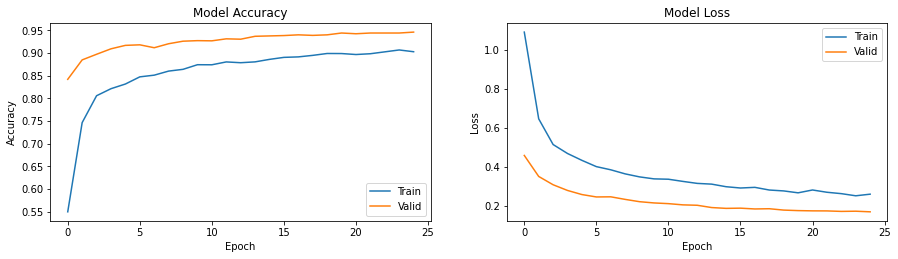

In [ ]:
import matplotlib.pyplot as plt
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(History.history['accuracy'])  
plt.plot(History.history['val_accuracy'])  
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Valid']) 
    
plt.subplot(222)  
plt.plot(History.history['loss'])  
plt.plot(History.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Valid']) 

plt.show()

In [ ]:
#-------------------------Evaluation Curves---------------------------------------------------------

lw = 2
from sklearn.metrics import roc_curve, auc
from scipy import interp

fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = model.predict(X_test, batch_size=32)
n_classes = 4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
   
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

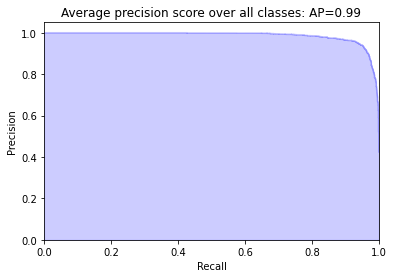

In [ ]:
#------------PR curve---------------
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
    #n_classes = y_test.shape[1]
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")
    #print('Average precision score, micro-averaged over all classes: {0:0.2f}'
    #      .format(average_precision["micro"]))
plt.clf()
plt.figure(2)
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2, where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
    #                 **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision score over all classes: AP={0:0.2f}'.format(average_precision["micro"]))
plt.savefig('Precision-Recall.eps', format='eps', dpi=1000)
plt.savefig('Precision-Recall.png', format='png', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

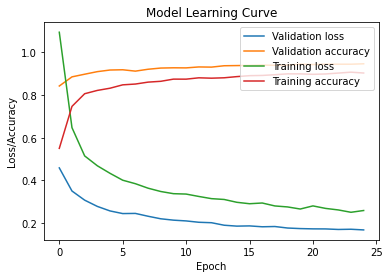

In [ ]:
#------------------Plot Learning Curve---------------
plt.clf() 
plt.figure(4)
plt.plot(History.history["val_loss"], label="val_loss")
plt.plot(History.history["val_accuracy"], label="val_accuracy")
plt.plot(History.history["loss"], label="train_loss")
plt.plot(History.history["accuracy"], label="train_acc")
plt.title('Model Learning Curve')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation loss', 'Validation accuracy', 'Training loss', 'Training accuracy'], loc='upper right')
plt.savefig('Learning-curve1.eps', format='eps', dpi=1000)
plt.savefig('Learning-curve1.png', format='png', bbox_inches='tight')

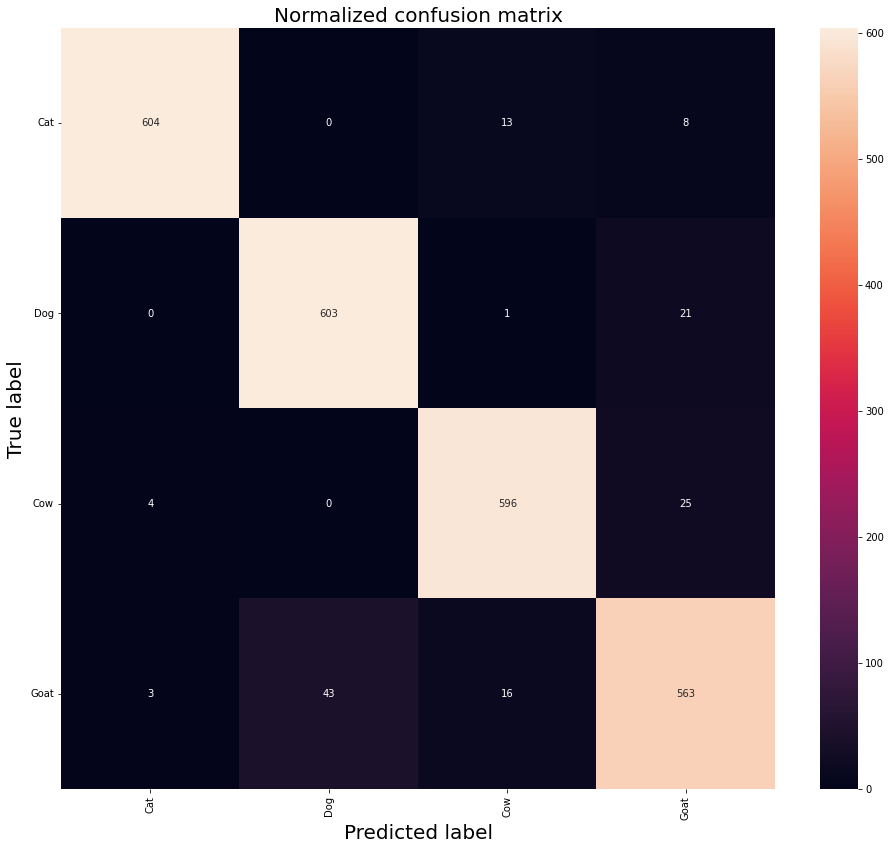

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
predictions = model.predict(X_test, steps=len(X_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)
y_pred = np.argmax(predictions, axis=-1)

y_true=np.argmax(Y_test, axis=-1)

cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
class_names = Animal_Labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted label', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True label', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Normalized confusion matrix', fontsize=20)

plt.savefig('ConMat.png')
plt.show()

In [ ]:
#------------------------------------------Con MAT2---------------============================-----
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix1(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.97 0.   0.02 0.01]
 [0.   0.96 0.   0.03]
 [0.01 0.   0.95 0.04]
 [0.   0.07 0.03 0.9 ]]


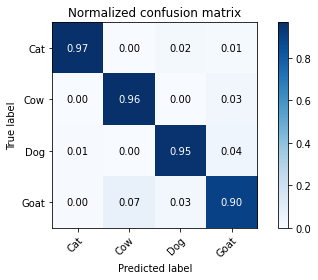

<Figure size 432x288 with 0 Axes>

In [ ]:
def plot_confusion_matrix1(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):

    if not title:
        if normalize: 
            title = 'Normalized confusion matrix'
        else: 
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    
# Only use the labels that appear in the data
#classes = classes[unique_labels(y_true, y_pred)]

    if normalize: 
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
        print("Normalized confusion matrix")
    else: 
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots() 
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title, ylabel='True label', xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

y_test = Y_test.argmax(axis=1)
y_pred = y_score.argmax(axis=1) 
lb = ['Cat', 'Cow', 'Dog', 'Goat']
# Plot normalized confusion matrix
plot_confusion_matrix1(y_test, y_pred, classes=lb, normalize=True, title='Normalized confusion matrix')
plt.show()
plt.savefig('CM.png', format='png', dpi=1000) 
plt.savefig('CM.tiff', format='tiff', dpi=1000)

In [ ]:
import pickle
model.save(outputmodel)
lbinarizer = open(r'/content/drive/MyDrive/datasets/ModelBinarizer.pickle', "wb")
lbinarizer.write(pickle.dumps(lb))
lbinarizer.close()

INFO:tensorflow:Assets written to: /content/drive/MyDrive/datasets/Model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
model.save(r'//content/drive/MyDrive/datasets/Model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
